# Preliminary LDA

Preliminary LDA looking at topic numbers

In [1]:
# import modules
import numpy as np
from time import time
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
import re
import matplotlib.pyplot as plt

% matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\medacola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\medacola\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\medacola\AppData\Local\Continuum\anaconda3\envs\topicmodel1\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# import data
t0 = time()
df = pd.read_pickle('labour_speeches_para_corpus.pkl')

print('Data loaded in %s seconds.' % str(time()-t0))

# show data to check
df.head()

Data loaded in 0.2041325569152832 seconds.


,Sent_id,Tokens,Speech,Paragraph,Year
0,1,"[meet, week, united, party, advancing, every, ...","Leader's speech, Brighton 2017","We meet here this week as a united Party, adva...",2017
1,2,"[privilege, speaking, brighton, city, long, hi...","Leader's speech, Brighton 2017",And it’s a privilege to be speaking in Bright...,2017
2,3,"[century, ago, brighton, teenage, shop, worker...","Leader's speech, Brighton 2017","It was over a century ago, here in Brighton, ...",2017
3,4,"[role, seconded, historic, resolution, trades,...","Leader's speech, Brighton 2017",In that role she seconded the historic resolu...,2017
4,5,"[became, labour, party, woman, margaret, bondf...","Leader's speech, Brighton 2017",That became the Labour Party and it was this...,2017


In [3]:
time_slices = df['Year'].value_counts().values.tolist()

In [4]:
# extract tokens as list
words = df['Tokens'].values

In [5]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
# gensim Dictionary function creates tokens -> tokenID dict
dictionary = Dictionary(words)
print('Number of unique words in initital documents:', len(dictionary))

org_dict = len(dictionary)

# Filter out words that occur less than 10 documents, or more than 70% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.7)
print('Number of unique words after removing rare and common words:', len(dictionary))

filt_dict = len(dictionary)

print('Token reduction of: ' + str((1-filt_dict/org_dict)*100)+'%')

Number of unique words in initital documents: 14874
Number of unique words after removing rare and common words: 4643
Token reduction of: 68.78445609788893%


In [6]:
# transform to bag of words
corpus = [dictionary.doc2bow(doc) for doc in words]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4643
Number of documents: 7195


In [7]:
doc = corpus[9]
bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)
# Print the top 5 words of the document alongside the count
for word_id, word_count in bow_doc[:5]:
    print(dictionary.get(word_id), word_count)

united 1
tories 1
ready 1
certainly 1
clearly 1


Average length: 54.52314107018763 words.


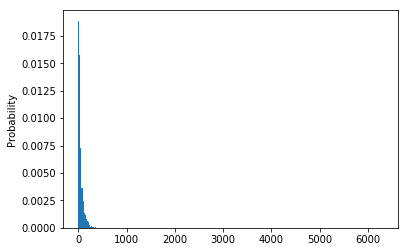

In [8]:
# word per sentence
len_art = [len(x.split(' ')) for x in df['Paragraph']]

%matplotlib inline
x = np.array(len_art)
plt.hist(x, density=True, bins=500)
plt.ylabel('Probability');

print('Average length: '+ str(np.mean(len_art))+' words.')

## Lets do DTM

In [15]:
# you can also copy the path down directly. Change this variable to your DTM executable before running.
dtm_path = "C:/dtm/dtm-win64.exe"

In [16]:
# takes a while to run just for num_topics = 2
from gensim.models.wrappers.dtmmodel import DtmModel

t0 = time()

model = DtmModel(dtm_path, corpus, time_slices, num_topics=2,
                 id2word=dictionary, initialize_lda=True)

print('Model fit completed in %s seconds.' % str(time()-t0))

Model fit completed in 1189.5190694332123 seconds.


### Save the model

In [17]:
# save the model for future tinkering

model.save('dtm_lab_speeches')

### Load the topic model

In [9]:
model = gensim.models.wrappers.dtmmodel.DtmModel.load('dtm_lab_speeches')

### Lets see how the topics are separated

In [10]:
topics = model.print_topics(num_words=2)
for topic in topics:
    print(topic)

0.014*party + 0.013*labour
0.019*people + 0.013*britain
0.014*party + 0.013*people
0.019*people + 0.013*britain
0.014*party + 0.013*people
0.018*people + 0.012*britain
0.013*party + 0.013*people
0.017*people + 0.012*britain
0.013*party + 0.012*people
0.016*people + 0.012*new


C:\Users\medacola\AppData\Local\Continuum\anaconda3\envs\topicmodel1\lib\site-packages\gensim\models\wrappers\dtmmodel.py:529: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


In [11]:
# Visualize the topics
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)

vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)

pyLDAvis.display(vis_wrapper)

C:\Users\medacola\AppData\Local\Continuum\anaconda3\envs\topicmodel1\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [12]:
def top_term_table(model, topic, slices, slice_labels, topn=10):
    '''Returns a dataframe with the top n terms in the topic for each of
    the given time slices.'''
    data = {}
    for time_slice in slices:
        data[slice_labels[time_slice]] = [
            term for p, term 
            in model.show_topic(topic, time=time_slice, topn=topn)
        ]
    return pd.DataFrame(data)

In [13]:
years = df['Year'].unique().tolist()

years

[2017,
 2016,
 2015,
 2014,
 2013,
 2012,
 2011,
 2010,
 2009,
 2008,
 2007,
 2006,
 2005,
 2004,
 2003,
 2002,
 2001,
 2000,
 1999,
 1998,
 1997,
 1996,
 1995,
 1994,
 1993,
 1992,
 1991,
 1990,
 1989,
 1988,
 1987,
 1986,
 1985,
 1984,
 1983,
 1982,
 1981,
 1980,
 1979,
 1978,
 1977,
 1976,
 1975,
 1974,
 1973,
 1972,
 1971,
 1970,
 1969,
 1968,
 1967,
 1966,
 1965,
 1964,
 1951,
 1950,
 1949,
 1948,
 1947,
 1946,
 1924]

In [14]:
for topic in range(2):
    print('Topic %d' % topic)
    print(top_term_table(model, topic, [2, 18, 50], years))
#     print('-'*80)
    print()

Topic 0
         2015        1999        1967
0       party      people  government
1      people       party          us
2      labour          us         one
3          us  government       would
4         one      labour       party
5     country       would       great
6  government         one      policy
7        know         say      labour
8         let     country        time
9        said        know        work

Topic 1
         2015        1999        1967
0      people      people      social
1     britain  government         new
2     country     britain  industrial
3         new     country     britain
4  government         new    industry
5         one        want    economic
6       every        make       world
7      change       world          us
8      labour      labour       years
9        work         get      people



In [40]:
def term_distribution(model, term, topic):
    '''Extracts the probability over each time slice of a term/topic pair.'''
    word_index = model.id2word.token2id[term]
    topic_slice = np.exp(model.lambda_[topic])
    topic_slice = topic_slice / topic_slice.sum(axis=0)
    return topic_slice[word_index]

In [41]:
def plot_terms(x, model, topic, terms, title=None, hide_y=True):
    '''Creates a plot of term probabilities over time in a given topic.'''
    fig, ax = plt.subplots()
    plt.style.use('fivethirtyeight')
    
    for term in terms:
        ax.plot(x, term_distribution(model, term, topic), label=term)
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if hide_y:
        ax.set_yticklabels([])
    ax.set_ylabel('Probability')
    if title:
        ax.set_title(title)
    return fig, ax

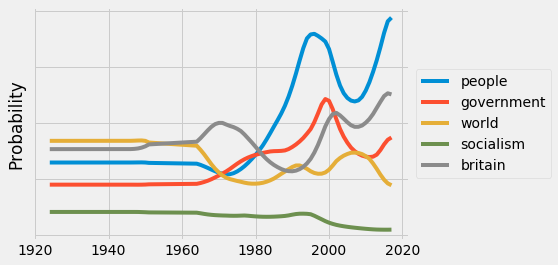

In [43]:
plots = [
    (None, ['people', 'government', 'world', 'socialism', 'britain']),
#     ('Africa (colonialism)', None, ['colonial', 'portugal', 'racist', 'territory', 'independence']),
#     ('Africa (apartheid)', None, ['apartheid', 'south']),
]
for title, terms in plots:
    fig, ax = plot_terms(years, model, 1, terms, title=title)

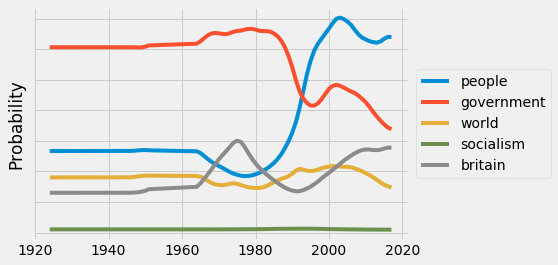

In [45]:
plots = [
    (None, ['people', 'government', 'world', 'socialism', 'britain']),
#     ('Africa (colonialism)', None, ['colonial', 'portugal', 'racist', 'territory', 'independence']),
#     ('Africa (apartheid)', None, ['apartheid', 'south']),
]
for title, terms in plots:
    fig, ax = plot_terms(years, model, 0, terms, title=title)